In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import requests
from io import StringIO
from datetime import datetime
import matplotlib.dates as mdates
from datetime import timedelta

In [2]:
%matplotlib inline

In [37]:
# data downloaded from http://www.healthdata.org/covid/data-downloads
# each available file was renamed to 'Hops_xx_yy.csv' where xx is month and yy is day it was published
data_path = './ihme_data/'
files = [x for n, d, f in os.walk(data_path) for x in f]

In [38]:
# make one big dataframe including the publish date
def make_df(filename):
    tdf = pd.read_csv(os.path.join(data_path, filename))
    d = '2020-' + filename[-9:-4].replace('_', '-')
    tdf['publish_date'] = pd.to_datetime(d)
    return tdf

df = pd.concat([make_df(f) for f in files])
df['date'] = pd.to_datetime(df.date)

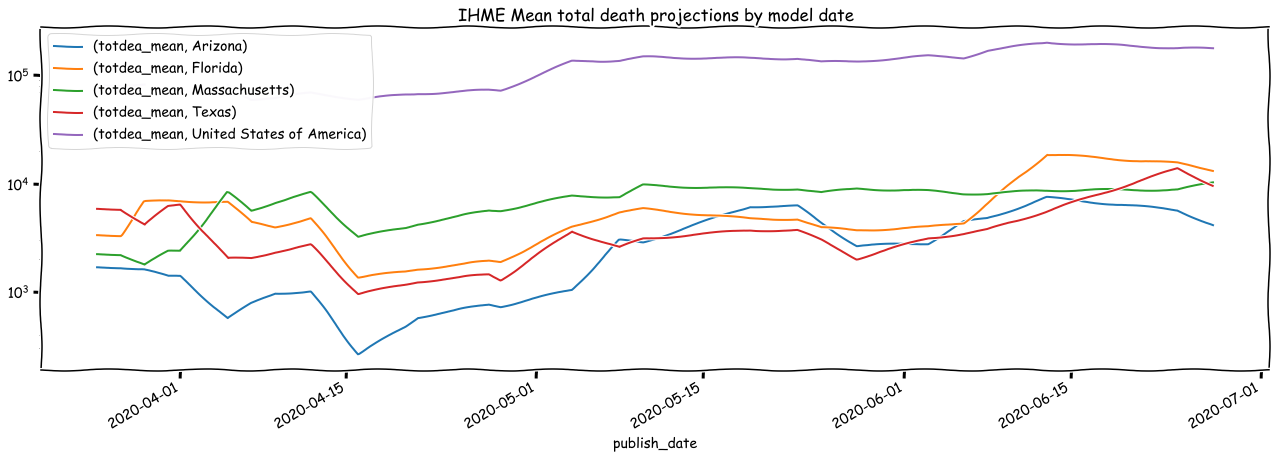

In [39]:
with plt.xkcd():
    plt.rcParams['figure.figsize'] = (22,7)
    df[df.location_name.isin(['United States of America', 'Massachusetts', 'Florida', 'Arizona', 'Texas'])].\
       groupby(['publish_date', 'location_name']).\
       agg({'totdea_mean': 'max'}).unstack().\
       plot(logy=True, title='IHME Mean total death projections by model date')
    plt.legend(loc=2)


In [6]:
# let's make the real version of this graph https://www.realclearpolitics.com/articles/2020/05/21/how_fear_groupthink_drove_unnecessary_global_lockdowns_143253.html

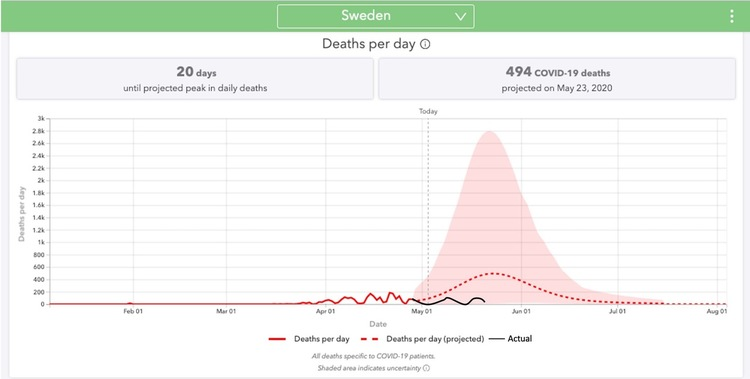

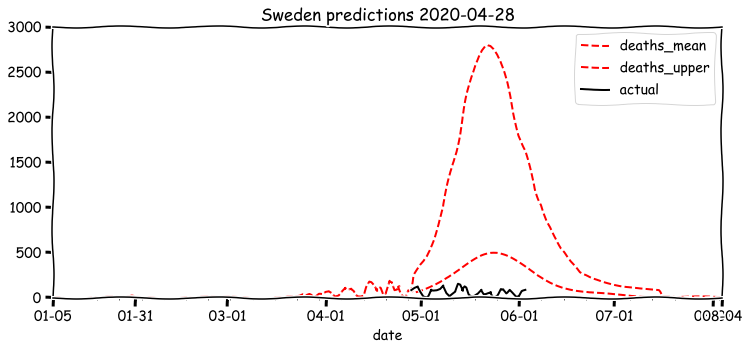

In [40]:
plt.rcParams['figure.figsize'] = (12,5)
with plt.xkcd():
    logy = False
    pred_date = '2020-04-28'
    latest_date = '2020-06-13'
    # predictions from a specific date
    ax = df.loc[
        (df.location_name=='Sweden')&(df.publish_date==pred_date),
        ['date', 'deaths_mean', 'deaths_upper']
    ].set_index('date').\
        plot(
            logy=logy,
            style=['r--','r--']
        )

    # now this is actual deaths from 5/25
    df.loc[
            (df.location_name=='Sweden')&(df.publish_date=='2020-06-13')&(df.deaths_lower==df.deaths_upper)&
            (df.date>=pd.Timestamp(pred_date))&(df.date<=pd.Timestamp(latest_date)),
            ['date', 'deaths_upper']
    ].set_index('date').rename(columns={'deaths_upper': 'actual'}).\
        plot(ax=ax, logy=logy, style=['k'])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.set_ylim(-10, 3000)
    ax.set_title(f'Sweden predictions {pred_date}')
    
    ax.fill_between(
        df[(df.location_name=='Sweden')&(df.publish_date==pred_date)].date,
        df[(df.location_name=='Sweden')&(df.publish_date==pred_date)].deaths_upper, 
        alpha=0.2, color='r')

In [225]:
def sqr_error(pred, actual):
    sqr_error = ((pred - actual) ** 2).mean()
    return sqr_error

def mean_sqr_error(df, location_name, pred_date, rolling=7, window=90):
    if pd.Timestamp(pred_date) + pd.Timedelta(days=window) > df.date.max():
        cutoff_date = df.date.max()
    else:
        cutoff_date = pd.Timestamp(pred_date) + pd.Timedelta(days=window)
    pred_df = df.loc[
        (df.location_name==location_name)&(df.publish_date==pred_date)&
            (df.date>=pd.Timestamp(pred_date))&(df.date<=cutoff_date),
        ['date', 'deaths_mean']
    ].set_index('date')
    actual_df = df.loc[
        (df.location_name==location_name)&(df.publish_date==df.publish_date.max())&
        (df.date>=pd.Timestamp(pred_date)-pd.Timedelta(days=rolling))&(df.date<=cutoff_date),
        ['date', 'deaths_upper'],
    ].set_index('date').rolling(rolling).mean().fillna(0)
    return sqr_error(pred_df.deaths_mean, actual_df.deaths_upper)

def net_error(df, location_name, pred_date, cutoff_date, rolling=7):
    pred_df = df.loc[
        (df.location_name==location_name)&(df.publish_date==pred_date)&
            (df.date>=pd.Timestamp(pred_date))&(df.date<=cutoff_date),
        ['date', 'deaths_mean']
    ].set_index('date')
    actual_df = df.loc[
        (df.location_name==location_name)&(df.publish_date==cutoff_date)&
        (df.date>=pd.Timestamp(pred_date)-pd.Timedelta(days=rolling))&(df.date<=cutoff_date),
        ['date', 'deaths_upper'],
    ].set_index('date').rolling(rolling).mean().fillna(0)
    return int((actual_df.deaths_upper - pred_df.deaths_mean).sum())


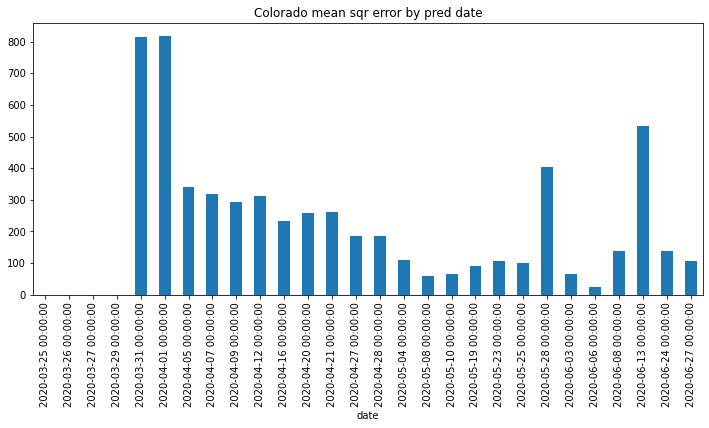

In [236]:
location = 'Colorado'
errors = [{'date': x, 'error': mean_sqr_error(df, location, x, rolling=14)}
    for x in df[df.location_name==location].publish_date.unique()
]
pd.DataFrame(errors).set_index('date').sort_values(by='date').\
    error.plot(kind='bar', title=f"{location} mean sqr error by pred date")

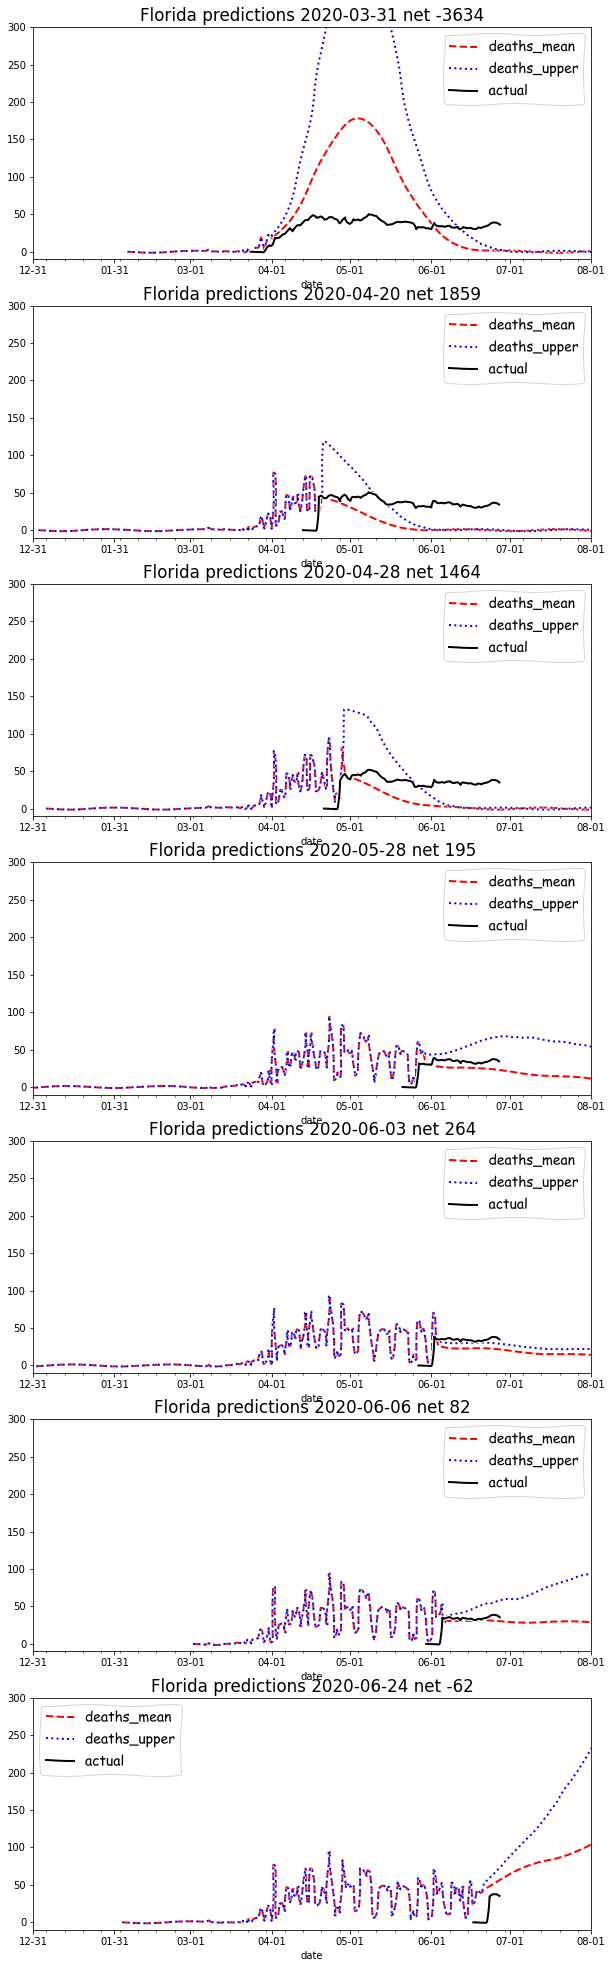

In [233]:
dates = ['2020-03-31', '2020-04-20', '2020-04-28', '2020-05-28', '2020-06-03', '2020-06-06', '2020-06-24']
latest_date = '2020-06-27'
country = 'Florida'
fig, axs = plt.subplots(len(dates), figsize=(10, len(dates)*5))
logy = False
for (pred_date, ax) in zip(dates, axs):
    with plt.xkcd():
        # predictions from a specific date
        df.loc[
            (df.location_name==country)&(df.publish_date==pred_date),
            ['date', 'deaths_mean', 'deaths_upper']
        ].set_index('date').\
            plot(
                logy=logy,
                style=['r--','b:'],
                ax=ax
            )

        # now this is actual deaths from pre_date through latest_date
        df.loc[
            (df.location_name==country)&(df.publish_date==latest_date)&(df.deaths_lower==df.deaths_upper)&
            (df.date>=pd.Timestamp(pred_date)-pd.Timedelta(days=7))&(df.date<=pd.Timestamp(latest_date)),
            ['date', 'deaths_upper']
        ].set_index('date').rename(columns={'deaths_upper': 'actual'}).rolling(7).mean().fillna(0).\
            plot(ax=ax, logy=logy, style=['k'])
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.set_ylim(-10, 300)
        ax.set_xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2020-08-01'))
        #ax.annotate(f"mean sqr error: {mean_sqr_error(df, country, pred_date)}", (10,10))
        ax.set_title(f'{country} predictions {pred_date} net {net_error(df, country, pred_date, latest_date)}')


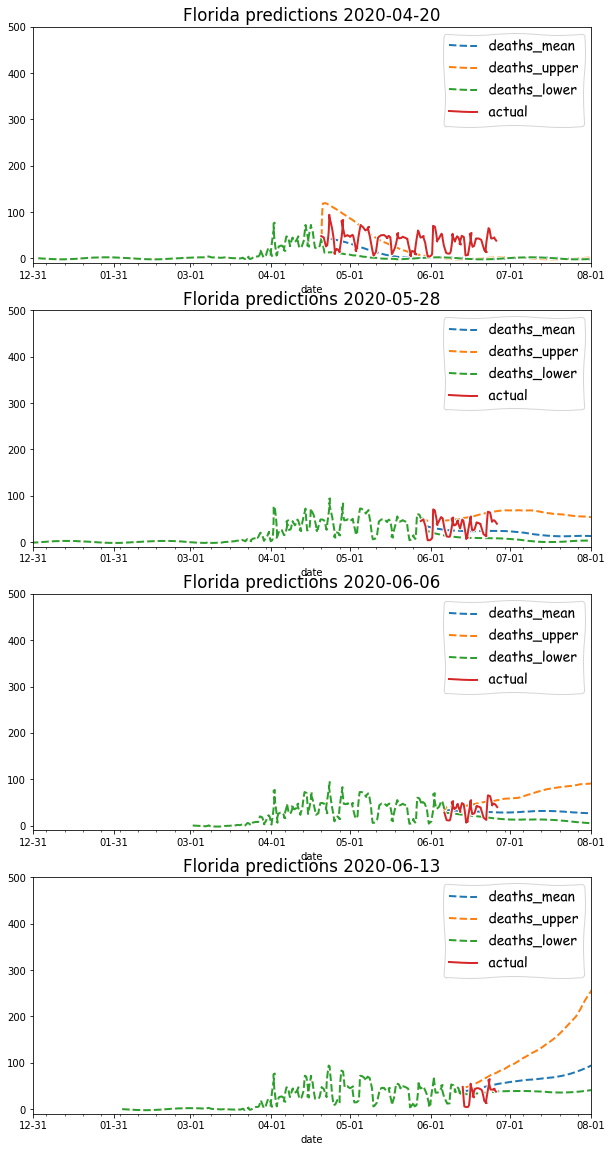

In [231]:
dates = ['2020-04-20', '2020-05-28','2020-06-06', '2020-06-13']
latest_date = '2020-06-27'
country = 'Florida'
fig, axs = plt.subplots(len(dates), figsize=(10, len(dates)*5))
logy = False
for (pred_date, ax) in zip(dates, axs):
    with plt.xkcd():
        # predictions from a specific date
        df.loc[
            (df.location_name==country)&(df.publish_date==pred_date),
            ['date', 'deaths_mean', 'deaths_upper', 'deaths_lower']
        ].set_index('date').\
            plot(
                logy=logy,
                style=['--','--','--'],
                ax=ax
            )

        # now this is actual deaths from pre_date through latest_date
        df.loc[
            (df.location_name==country)&(df.publish_date==latest_date)&(df.deaths_lower==df.deaths_upper)&
            (df.date>=pd.Timestamp(pred_date))&(df.date<pd.Timestamp(latest_date)),
            ['date', 'deaths_upper']
        ].set_index('date').rename(columns={'deaths_upper': 'actual'}).\
            plot(ax=ax, logy=logy)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.set_ylim(-10, 500)
        ax.set_xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2020-08-01'))
        ax.set_title(f'{country} predictions {pred_date}')

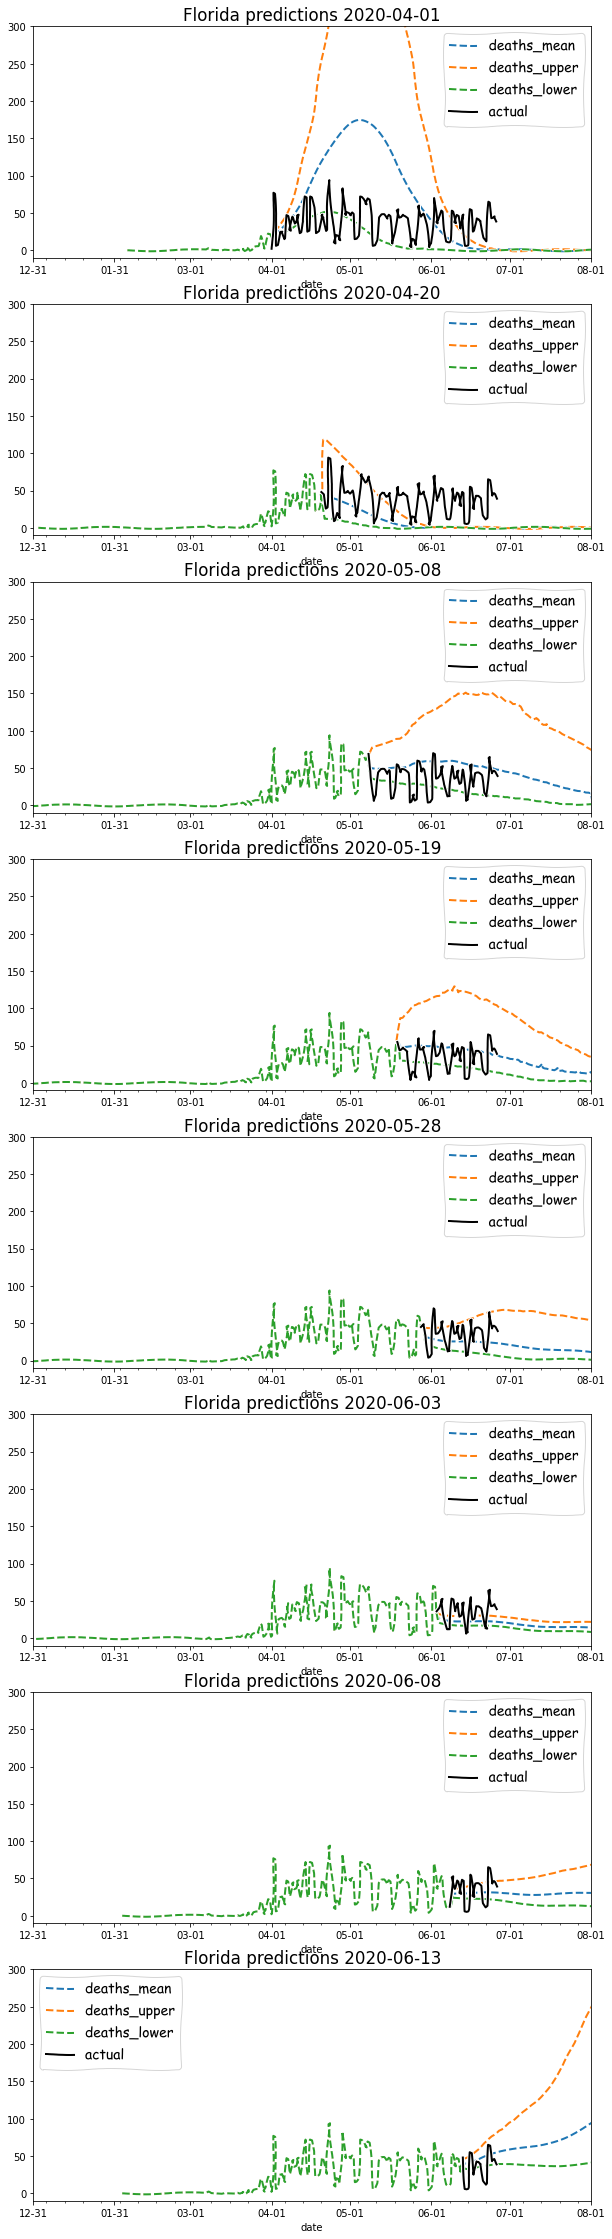

In [44]:
# what happened in Florida? 4 weeks ago someone used the chart to make a point, did it work?
# https://floridapolitics.com/archives/331753-peak-of-daily-covid-19-deaths-still-in-floridas-future-model-shows
dates = ['2020-04-01', '2020-04-20', '2020-05-08', '2020-05-19', '2020-05-28', '2020-06-03', '2020-06-08', '2020-06-13']
latest_date = '2020-06-27'
country = 'Florida'
fig, axs = plt.subplots(len(dates), figsize=(10, len(dates)*5))
logy = False
for (pred_date, ax) in zip(dates, axs):
    with plt.xkcd():
        # predictions from a specific date
        df.loc[
            (df.location_name==country)&(df.publish_date==pred_date),
            ['date', 'deaths_mean', 'deaths_upper', 'deaths_lower']
        ].set_index('date').\
            plot(
                logy=logy,
                style=['--','--','--'],
                ax=ax
            )

        # now this is actual deaths from pre_date through latest_date
        df.loc[
            (df.location_name==country)&(df.publish_date==latest_date)&(df.deaths_lower==df.deaths_upper)&
            (df.date>=pd.Timestamp(pred_date))&(df.date<pd.Timestamp(latest_date)),
            ['date', 'deaths_upper']
        ].set_index('date').rename(columns={'deaths_upper': 'actual'}).\
            plot(ax=ax, logy=logy, style=['k'])
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.set_ylim(-10, 300)
        ax.set_xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2020-08-01'))
        ax.set_title(f'{country} predictions {pred_date}')

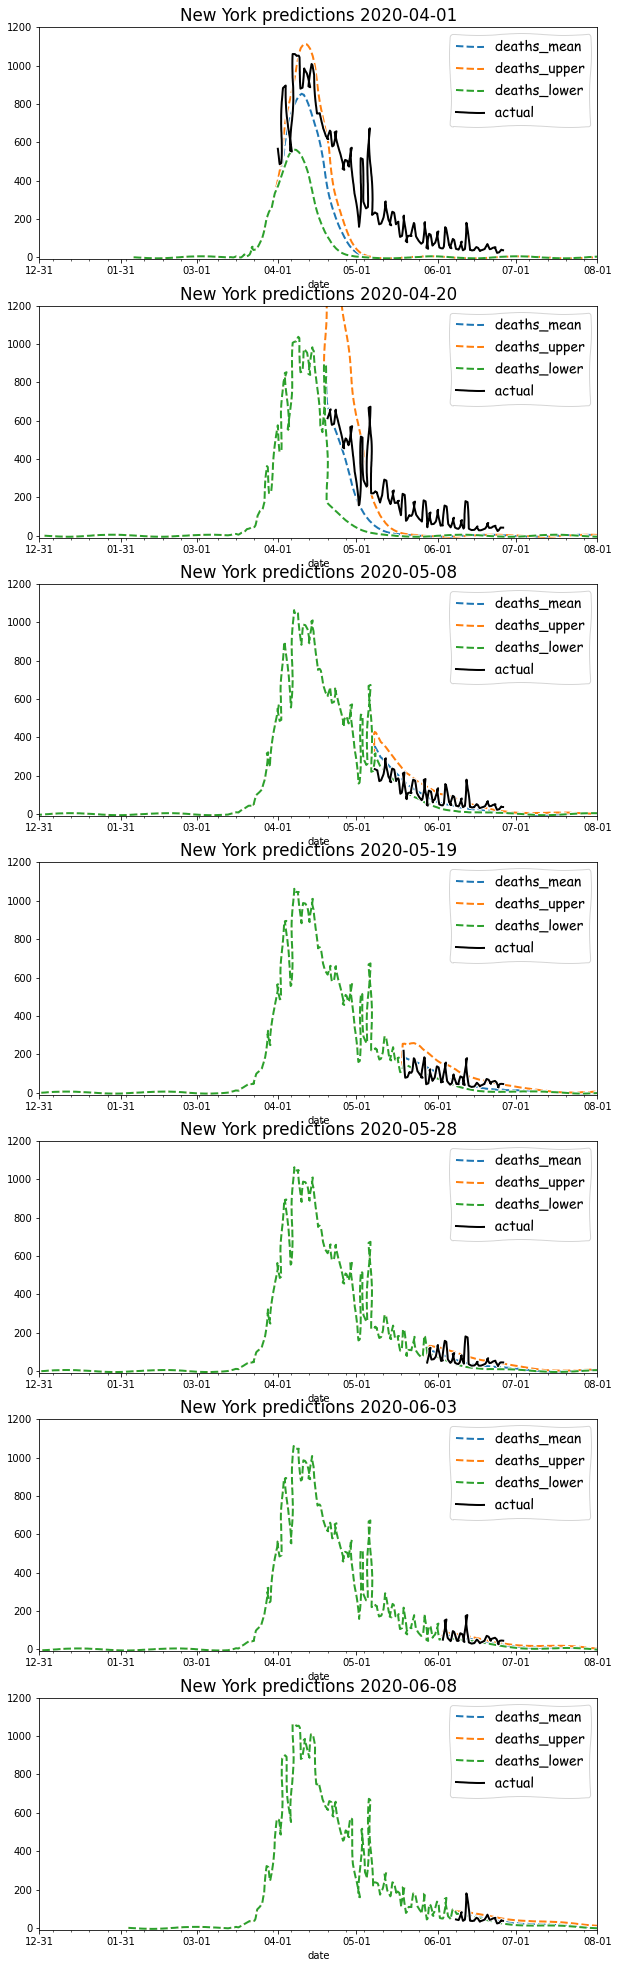

In [43]:
# what happened in Florida? 4 weeks ago someone used the chart to make a point, did it work?
# https://floridapolitics.com/archives/331753-peak-of-daily-covid-19-deaths-still-in-floridas-future-model-shows
dates = ['2020-04-01', '2020-04-20', '2020-05-08', '2020-05-19', '2020-05-28', '2020-06-03', '2020-06-08']
latest_date = '2020-06-27'
country = 'New York'
fig, axs = plt.subplots(len(dates), figsize=(10, len(dates)*5))
logy = False
for (pred_date, ax) in zip(dates, axs):
    with plt.xkcd():
        # predictions from a specific date
        df.loc[
            (df.location_name==country)&(df.publish_date==pred_date),
            ['date', 'deaths_mean', 'deaths_upper', 'deaths_lower']
        ].set_index('date').\
            plot(
                logy=logy,
                style=['--','--','--'],
                ax=ax
            )

        # now this is actual deaths from pre_date through latest_date
        df.loc[
            (df.location_name==country)&(df.publish_date==latest_date)&(df.deaths_lower==df.deaths_upper)&
            (df.date>=pd.Timestamp(pred_date))&(df.date<pd.Timestamp(latest_date)),
            ['date', 'deaths_upper']
        ].set_index('date').rename(columns={'deaths_upper': 'actual'}).\
            plot(ax=ax, logy=logy, style=['k'])
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.set_ylim(-10, 1200)
        ax.set_xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2020-08-01'))
        ax.set_title(f'{country} predictions {pred_date}')

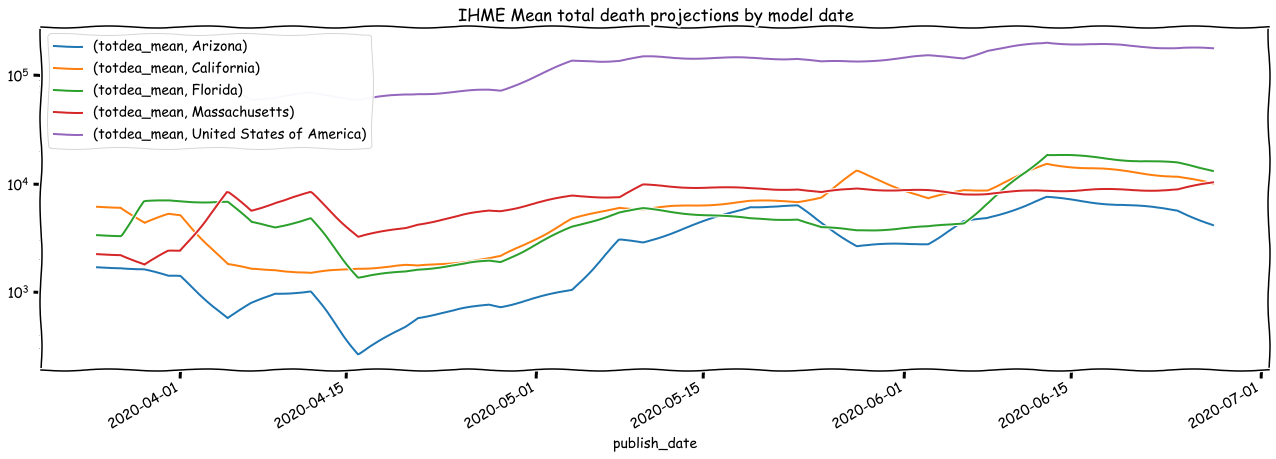

In [47]:
# a little more florida, how volatile over time?
with plt.xkcd():
    plt.rcParams['figure.figsize'] = (22,7)
    df[df.location_name.isin(['United States of America', 'Arizona', 'Florida', 'Massachusetts', 'California'])].\
       groupby(['publish_date', 'location_name']).\
       agg({'totdea_mean': 'max'}).unstack().\
       plot(logy=True, title='IHME Mean total death projections by model date')
    plt.legend(loc=2)


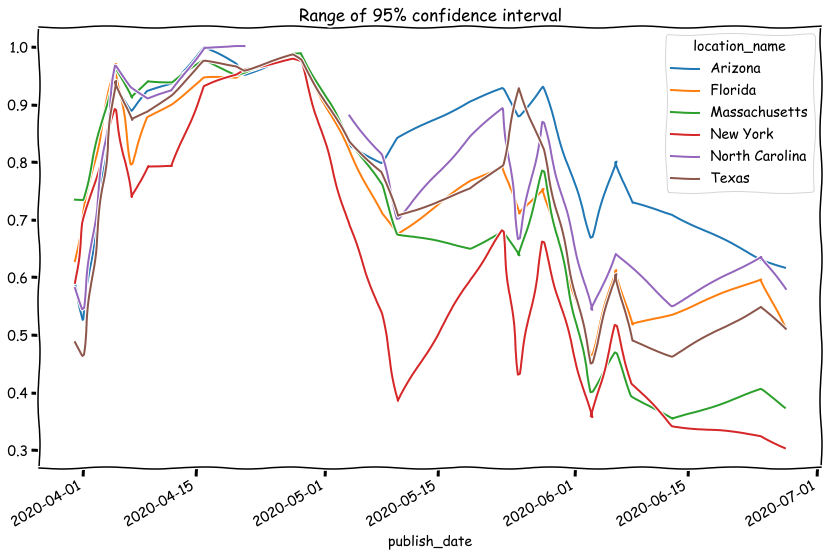

In [48]:
# can we look at the uncertainty in a model for any given country by looking at the 95ci?
countries=['Arizona', 'North Carolina', 'Florida', 'Massachusetts', 'Texas', 'New York']
delta = df.loc[(df.location_name.isin(countries))&(df.date==df.publish_date+timedelta(days=14))].\
    groupby(['location_name', 'publish_date']).\
    agg({'deaths_upper': 'max', 'deaths_lower': 'max'})
delta['range'] = delta.deaths_upper - delta.deaths_lower
delta['ci_ratio'] = delta.range / delta.deaths_upper
with plt.xkcd():
    plt.rcParams['figure.figsize'] = (14,9)
    delta.unstack(0).ci_ratio.plot(title=f'Range of 95% confidence interval')